<a href="https://colab.research.google.com/github/luqmanbuang/Aircraft-Engine-Lifetime-Prediction-with-Machine-Learning/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#1. The dataset

Dataset is divided into training and test subsets consisting of multiple multivariate time series. Each time series is from a different engine unit – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine unit starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. However in the dataset used in this project, df_FD001, the engines are only sujected to a single operational setting and hence does not contribute to much degredation learning. Additionaly, the data is contaminated with sensor noise.
<br>  
The engine is operating normally at the start of each time series and is assumed to be at perfect health. It develops a fault at some point during the series. In the <ins>training set</ins>, the fault grows in magnitude until system failure. **In the test set, the time series ends some time prior to system failure.**
<br>  
The **objective of this project is to predict the number of remaining operational cycles before failure in the test set**, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. A vector of the actual Remaining Useful Life (RUL) values for the test data is available and will be used to compare the accuracy of the prediction model.  
<br> 
The screenshot below shows the first five rows of engine unit 1. Each row represents a screenshot of the same engine unit (unit 1) at different times — called cycles. In the test and train dataset, there are 100 of such engine units with varying numbers of cycles each. 21 columns representing data from 21 different engine sensors are included along each row. For simplicity, these sensors are called sensors S1 to S21. For example, Sensor 1 is the sensor that detects the total temperature at the fan inlet while Sensor 8 tracks the fan speed of the engine in RPM.
<br>  
![Dataset example](https://drive.google.com/uc?id=1hEt0xMQv-6IOwO1A5kMkbL8wkPIBlkcX) 
<br>  
Degredation of the engine health can be observed by plotting the data from these sensors. In a sample plot below, we can see that as the engine's health deteriorates over time the engine's core speed increases. A possible explanation why this might occur is that the engine needs to generate a higher RPM in order to produce or maintain the same power output. Similar degradation patterns can be observed in the other sensors. The goal is to <ins>let the machine learning algorithms learn the degradation patterns and its corelation to the engine's health</ins> in order to ultimately predict the engine's Remaining Useful Life in operation. The training dataset will be used to train the machine learning algorithm, while the test dataset is used to validate its accuracy.  
<br>  
![sensor degredation](https://drive.google.com/uc?id=1n5YQFTOmvdPyro86zeCB3VDMXhLTD54G)

##1.1. Importing and preprocessing the dataset
Firstly, both the train and test datasets are uploaded into the notebook and preprocessed to prepare it for the machine learning process. Plotting the different sensors for every engine units uncovers that some sensors do not contain characteristics that show engine degredation in comparison to the example in the previous section. Instead they exhibit constant and flatline data output. Sensors with constant data measurements such as Op3, S1, S5, S6, S9, S16, S10, S18, S19 do not provide any useful degradation information for the RUL predictions and are subsequently removed.
<br> 
<br>  

<p align="center">Plotting the different sensors for every engine units in the train dataset</p>

![Dataset example](https://drive.google.com/uc?id=1JMP_FgtpRi8dx3MO441snXgc18phsOt_)
<br>  
After they are removed, the train and test datasets are combined together for feature scaling using `sklearn.preprocessing.MinMaxScaler()` to normalise their features between between zero and one and so that they contain a similar scale. After which the train and test datasets are split again.



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

#Importing both test and train datasets
df_test_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/test_FD001.txt', sep=' ', header=None)
df_train_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/train_FD001.txt', sep=' ', header=None)


# dropping NAN values
df_test_FD001 = df_test_FD001.dropna(axis=1, how='all')
df_train_FD001 = df_train_FD001.dropna(axis=1, how='all')

# Naming the columns
df_test_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

df_train_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

# data preprocessing; removing unnecessary data
df_test_FD001.drop(['Op3','S1', 'S5', 'S6', 'S9', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)
df_train_FD001.drop(['Op3','S1', 'S5', 'S6', 'S9', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)

# test dataset begins with unit 101 to differentiate from the train dataset
df_test_FD001['unit'] += 100

# Combine the two datasets into a single dataframe
df_combined = pd.concat([df_train_FD001, df_test_FD001]) 

# Perform scalling on the the combined dataset so that their scale is the same
scaler = MinMaxScaler()
df_combined.iloc[:,2:18] = scaler.fit_transform(df_combined.iloc[:,2:18])

# Split them again after performing scalling
df_train_FD001 = df_combined[(df_combined.unit <= 100)]
df_test_FD001 = df_combined[(df_combined.unit >= 101)]

# After separation, the first unit of the test dataset is reset to 0 again
df_test_FD001['unit'] -= 100

#2. Calculation

##Remaining Useful Life (RUL)
The Remaining Useful Life of an engine unit at a cycle is calculated by subtracting the number of cycles where the engine stops oprating (the maximum number of cycles), to the current cycle that we want to calculate its RUL. This value represents the amount of cycles remaining before engine failure. *For an engine that lasts 200 cycles, the RUL of that engine will be 200 at its very first cycle, and 0 at its final or maximum cycle.*  
![RUL calculation](https://drive.google.com/uc?id=1plHNZOQJv5CNyfkJ70AaHsya_7VBoMhj)

## Health Index (H.I.)
The RUL can be used to calculate the health index of the engine. The health index of the engine represents the state of the engine's health where values closer to one represents a healthier engine and values closer to 0 signifies that the engine reaching the end of its operational life. The health index is caculated by dividing the the current cycle of the time series by the maximum cycles of the unit. *For example, calculating the H.I of an engine at its very first cycle where it is at best health returns a value of one as the RUL of the engine at the first cycle is also equals to the maximum cycles of the engine.*

![HI calculation](https://drive.google.com/uc?id=1Zbk_7BXxpUSJWeA2JppKUnvlXF9-E8vV)

In [3]:
# Finding the maximum cycle of an engine unit which is used to find its Remaining Useful Life (RUL)
df_train_FD001 = pd.merge(df_train_FD001, df_train_FD001.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
df_train_FD001.rename(columns={"cycles_x": "cycles", "cycles_y": "Total Cycles"}, inplace=True)

df_train_FD001['RUL'] = df_train_FD001['Total Cycles'] - df_train_FD001['cycles']

# Defining the Health Index, where value of 1 denotes healthy engine and 0 denotes failure
def HealthIndex(dataFrame,q):
    return(dataFrame.RUL[q]-dataFrame.RUL.min()) / (dataFrame.RUL.max()-dataFrame.RUL.min())

healthIndex_q = []
healthIndex = []

for i in range(df_train_FD001['unit'].min(), df_train_FD001['unit'].max() + 1):
    dataFrame = df_train_FD001[df_train_FD001.unit == i]
    dataFrame = dataFrame.reset_index(drop = True)
    for q in range(len(dataFrame)):
        healthIndex_q = HealthIndex(dataFrame, q)
        healthIndex.append(healthIndex_q)

df_train_FD001['Health Index'] = healthIndex

#3. Defining test and train data
##Train data
Sensor data values from the **train dataset** are defined as X_train and the Health Index calculated in the earlier section defined as y_train. The X_train and y_train data will be used to fit and train the machine learning models.  
##Test data
Sensor data values from the **test dataset** is defined as X_test. What is being predicted is the Health Index of the engine. <ins>When X_test is passed into the trained machine learning model, it is able to return a prediction of engines' Health Index.</ins>

In [4]:
# Defining train values that will be used to train the machine learning model
X_train = df_train_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values
y_train = df_train_FD001[['Health Index']].values.ravel()

# Defining test values that will be used to perform prediction based on the trained model
X_test = df_test_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values

#4. Machine Learning Models
For this project, three machine learning models are used to predict the RUL of an engine.  
The models used are: 1) Linear Regression 2) K Nearest Neighbour 3) Simple Neural Network model.

## 4.1. Linear Regression model
The default linear regression model is used in this project

In [5]:
from sklearn.linear_model import LinearRegression
lreg_model = LinearRegression()
lreg_model.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 4.2. KNN Regressor Model
The default linear regression model is used in this project

In [6]:
from sklearn.neighbors import KNeighborsRegressor

knr_model = KNeighborsRegressor(n_neighbors=6)
knr_model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform')

## 4.3. Neural Network Model
The neural network model is defined with 16 inputs nodes that comes from the engine sensor datas. They are then passed through a single hidden layer with 50 nodes, with a single output. Where is then trained over 55 epochs.

In [7]:
# # Importing keras deep learning API into colab notebook
# from keras.models import Sequential
# from keras.layers.core import Dense, Activation
# from keras.wrappers.scikit_learn import KerasRegressor

# # Defining Neural Network model
# nn_model = Sequential()
# nn_model.add(Dense(50, input_dim=16, kernel_initializer='normal', activation='relu'))
# nn_model.add(Dense(1, activation='relu'))

# # Compiling model
# nn_model.compile(loss='mean_squared_error', optimizer='adam')

# # Training the Neural Network model
# nn_model.fit(X_train, y_train, epochs = 55, shuffle=True, verbose = 0)

## 4.4. Saved Neural Network Model
Alternatively, the best Neural Network model as a result of multiple runs was saved and can be uploaded again so that the most accurate model can be retrieved again for an accurate prediction. This method is used for the subsequent sections.

In [8]:
import keras

# from tensorflow import keras
nn_model = keras.models.load_model('/content/gdrive/My Drive/Capstone/BestModel')

#5. `MachineLearningModel()` class and its methods
The `MachineLearningModel()` class is created to reduce code duplication when calling multiple machine learning models to predict the engine degredation. The details of its methods are further explained below.

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Apply the default theme
sns.set_theme()
sns.set(font_scale=1.5)
style = plt.style.context("seaborn-whitegrid")

class MachineLearningModel:
  def __init__(self,model,name,testDataFrame, X_test, OutputDataFrame = None):
    self.model = model
    self.name = name
    self.testDataFrame = testDataFrame
    self.X_test = X_test

    # Values of the predictions and calculations are stored in the test dataframe by default unless an alternate dataframe is specified 
    if OutputDataFrame is not None:
      self.OutputDataFrame = OutputDataFrame
    else:
      self.OutputDataFrame = self.testDataFrame

  def predict(self):    
    # Function predicts the Health Index values based on the trained machine learning model.
    Prediction = self.model.predict(self.X_test)

    # The predicted H.I. values are appended into the dataframe 
    self.OutputDataFrame[f'Pred_H.I._{self.name}'] = Prediction

    # Calculating the predicted maximum cycle of the engine units      
    self.OutputDataFrame[f'PredMaxCycles_{self.name}'] = self.OutputDataFrame['cycles'] / (1 - self.OutputDataFrame[f'Pred_H.I._{self.name}'])

  def PlotPredMaxCycles(self,displayUnit=1, display_mean = True):
    # Returning the average maximum cycle value of a particular engine unit
    df = self.OutputDataFrame[f'PredMaxCycles_{self.name}']
    meanValue = df[(self.OutputDataFrame['unit'] == displayUnit)][-10:].mean()
    print(f'Mean value of last 10 cycles of engine unit {displayUnit}: {meanValue}') 

    # plotting the predicted maximum cycles
    plt.figure(figsize = (18, 9))
    plt.style.context("seaborn-whitegrid")
    sns.set_style('whitegrid')
    plt.plot(df[(self.OutputDataFrame['unit'] == displayUnit)], linewidth=2.5)
    plt.xlabel('Cycles')
    plt.ylabel('Predicted Maximum Cycles')
    if display_mean == True:
      plt.axhline(meanValue, color="red", linestyle='dashed', linewidth=1.6)

    # set title and axis labels
    errorDist = plt.title(f'Predicted Maximum Cycles of engine unit {displayUnit}', x=0.5, y=1.05, ha='center', fontsize='xx-large')
    plt.setp(errorDist, color='black')

  def DataFrame(self, displayUnit=None, remove_sensor_data=False):
    df = self.OutputDataFrame
    if displayUnit:
      df = df[df['unit'] == displayUnit]

    # function returns dataframe
    droppedColumns = ['Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']
    if remove_sensor_data == True:
      df.drop(droppedColumns, axis=1, errors='ignore', inplace=True)
    return df

  def CalcPredMaxCycles(self):
    df = self.OutputDataFrame[f'PredMaxCycles_{self.name}']

    # Returns a uniform PredMaxCycles based on the calculated average of the last 10 cycles 
    for i in range(self.OutputDataFrame['unit'].min(), self.OutputDataFrame['unit'].max() + 1):
        df[(self.OutputDataFrame['unit'] == i)] = df[(self.OutputDataFrame['unit'] == i)][-10:].mean()
  
  def CalcPredRUL(self):
    self.OutputDataFrame[[f'Pred_RUL_{self.name}']] = self.OutputDataFrame[f'PredMaxCycles_{self.name}'] * self.OutputDataFrame[f'Pred_H.I._{self.name}']

    # Appending the RUL values of each engine unit into an array
    df =  self.OutputDataFrame[f'Pred_RUL_{self.name}']
    maxpred = []
    for i in range(1,101):
      maxpred.append(df[(self.OutputDataFrame['unit'] == i)].min())
    return maxpred  

  def PlotRUL(self, displayUnit = None, line_width=2.5):
    # Visualizing the predicted cycles of the engine units in the test dataset.
    # x-axis represents the cycles
    engine_unit = ''
    if displayUnit is None:
      df =  self.OutputDataFrame[f'Pred_RUL_{self.name}']
    else:
      df =  self.OutputDataFrame[f'Pred_RUL_{self.name}'][self.OutputDataFrame['unit'] == displayUnit]
      engine_unit = f'Engine {displayUnit}, '
    
    plt.figure(figsize = (18, 9))
    sns.set_style('whitegrid')   
    plt.plot(df, linewidth=line_width)
    plt.xlabel('Cycles')
    plt.ylabel('Predicted RUL')
    plt.title(f'Predicted Remaining Useful Life; {engine_unit}{self.name}', x=0.5, y=1.05, ha='center', fontsize='x-large')
      
  def DisplayEngineRUL(self, displayUnit=1):
    # Returning the Remaining useful life of an engine unit of the test dataset.
    # It is found by returning the minumum cycle to failure value of each engine unit
    df =  self.OutputDataFrame[f'Pred_RUL_{self.name}'] 
    value = df[(self.OutputDataFrame['unit'] == displayUnit)].min()
    print(f'Predicted RUL of unit {displayUnit}: {value}')

  def GetRMSE(self,actual,predicted):
    # Calculating the Root Mean Square Error of the actual and predicted values
    RMSE = mean_squared_error(actual, predicted, squared=False)
    return RMSE


The Results fataframe is defined where the results of the predictions and calculation for each ML models are stored. 

In [10]:
Results_nn = df_test_FD001[['unit', 'cycles']]
Results_knr = df_test_FD001[['unit', 'cycles']]
Results_lreg = df_test_FD001[['unit', 'cycles']]

#6. Prediction
Using the `MachineLearningModel()` class, the prediction of engine RUL using multiple machine learning models can be made without code duplication. In this section, the process is explained using the best performing model: Neural Networks.

##6.1 Neural Network model prediction
The `MachineLearningModel()` class accepts six attributes such as:

1.   Trained machine learning model
2.   The name of the model in a string data type used when storing their results — *eg.; 'nn', 'lreg', 'knr'*
3.   The test dataframe where the results are stored by default
4.   The values of the test set in `numpy.ndarray` type that is used to predict the model
5.   If specified, an alternative dataframe where the results are stored

```
class MachineLearningModel:
  def __init__(self,model,name,testDataFrame, X_test, OutputDataFrame = None):
    self.model = model
    self.name = name
    self.testDataFrame = testDataFrame
    self.X_test = X_test

    # Values of the predictions and calculations are stored in the test dataframe by default unless an alternate dataframe is specified 
    if OutputDataFrame is not None:
      self.OutputDataFrame = OutputDataFrame
    else:
      self.OutputDataFrame = self.testDataFrame
```
The `MachineLearningClass.predict()` method inputs the X_test data into the prediction model and saves the output into the dataframe. This output is named Pred_H.I._nn in this example or the Predicted Health Index of the engine. With the H.I predicted, the maximum cycles of the engine can be calculated by dividing the current cycle by one minus the Health Index. 

![predicted maximum cycles](https://drive.google.com/uc?id=1250YEDm1IfsoAWqYbXZASC6d5i8qjpfb)

```
  def predict(self):    
    # Function predicts the Health Index values based on the trained machine learning model.
    Prediction = self.model.predict(self.X_test)

    # The predicted H.I. values are appended into the dataframe 
    self.OutputDataFrame[f'Pred_H.I._{self.name}'] = Prediction

    # Calculating the predicted maximum cycle of the engine units      
    self.OutputDataFrame[f'PredMaxCycles_{self.name}'] = self.OutputDataFrame['cycles'] / (1 - self.OutputDataFrame[f'Pred_H.I._{self.name}'])
```




In [11]:
NeuralNetwork = MachineLearningModel(nn_model, 'nn', df_test_FD001, X_test, Results_nn)
NeuralNetwork.predict()

By displaying the last five rows of the dataframe, the predicted RUL of unit 100 based can be calculated by subtracting the final cycle with the predicted maximum cycle (198 - 222) which returns a value of 19. In other words, this means that it is predicted that the engine's operational life will end in approximately 24 cycles.

![Predicted RUL calculation](https://drive.google.com/uc?id=1U37h-6AQnS6VbtkgDK65uIVv7GdXGksO)

In [12]:
# displaying the last 5 rows of the dataframe
NeuralNetwork.DataFrame(100).tail()

,unit,cycles,Pred_H.I._nn,PredMaxCycles_nn
13091,100,194,0.137112,224.826355
13092,100,195,0.144416,227.914627
13093,100,196,0.146855,229.738129
13094,100,197,0.132384,227.058945
13095,100,198,0.111879,222.942581



Taking unit 20 for example, it is observed that the value of the predicted maximum cycles throughout the timeseries is noisy and unstable. In a perfect world this should not happen as the maximum cycles should be same throughout. As a result, in this project the **<ins>average value of the last ten cycles is used to represent the predicted maximum cycle of the entire engine unit</ins>**. For the purpose of this project, these average values are refered as the adjusted predicted maximum cycles. For the example plotted below, the dotted line represent the averaged value used.  

Also below is a snippet of the code used to determine this average value used in the `MachineLearningModel.PlotPredMaxCycles(displayUnit=1)` method.    
```
df = self.OutputDataFrame[f'PredMaxCycles_{self.name}']
meanValue = df[(self.OutputDataFrame['unit'] == displayUnit)][-10:].mean()
```



Mean value of last 10 cycles of engine unit 20: 209.6955108642578


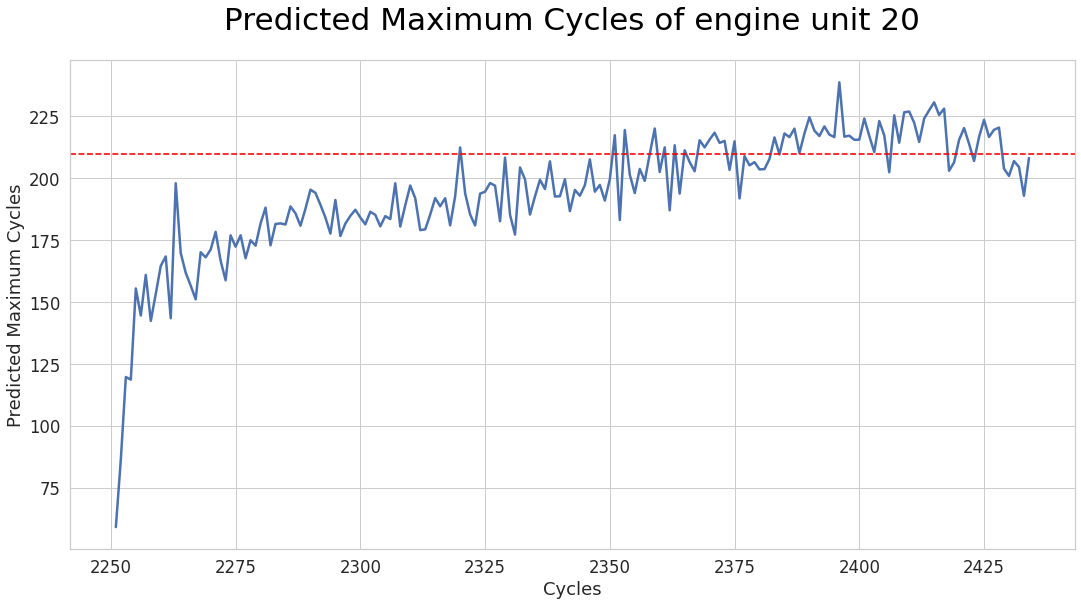

In [13]:
NeuralNetwork.PlotPredMaxCycles(20)

After averaging the predicted maximum cycles' values, we can see that it's values are now stable throughout the timeseries. Now we can proceed to calculate the RUL of the engine.

Mean value of last 10 cycles of engine unit 20: 209.69552612304688


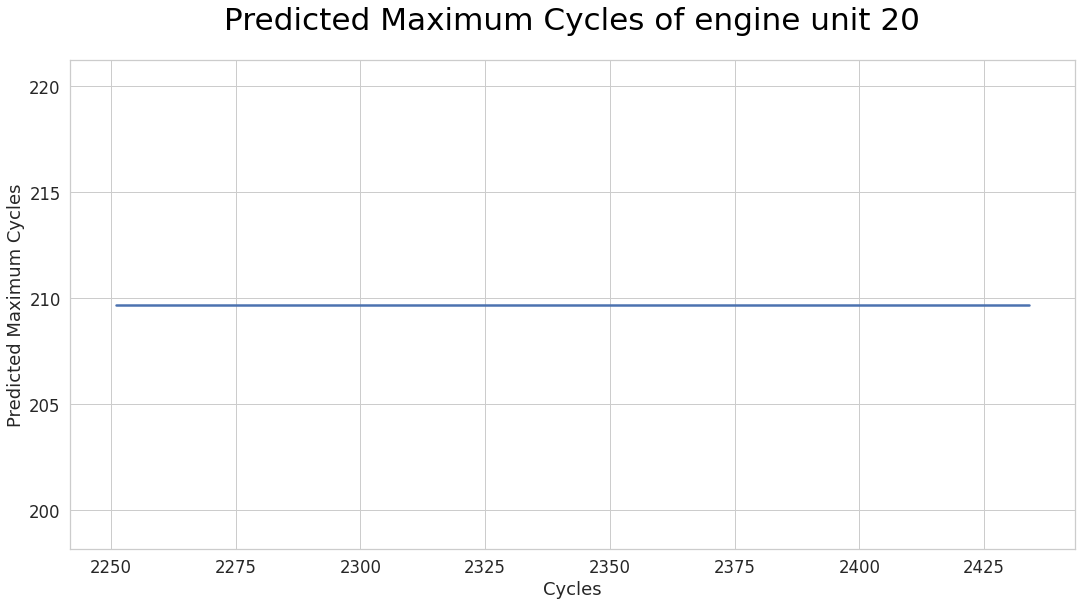

In [14]:
NeuralNetwork.CalcPredMaxCycles()
NeuralNetwork.PlotPredMaxCycles(20, display_mean=False)

With the values of the Predicted Maximum cycles averaged and stable throughout the timeseries, the Predicted RUL can now be calculated by multiplying the Predicted Maximum cycles with the Predicted Health Index.



In [15]:
RUL_nn = NeuralNetwork.CalcPredRUL()
NeuralNetwork.DataFrame()

,unit,cycles,Pred_H.I._nn,PredMaxCycles_nn,Pred_RUL_nn
0,1,1,0.982264,186.023041,182.723694
1,1,2,0.982387,186.023041,182.746613
2,1,3,0.984519,186.023041,183.143143
3,1,4,0.964011,186.023041,179.328339
4,1,5,0.967212,186.023041,179.923782
...,...,...,...,...,...
13091,100,194,0.137112,227.748001,31.226948
13092,100,195,0.144416,227.748001,32.890553
13093,100,196,0.146855,227.748001,33.445866
13094,100,197,0.132384,227.748001,30.150166


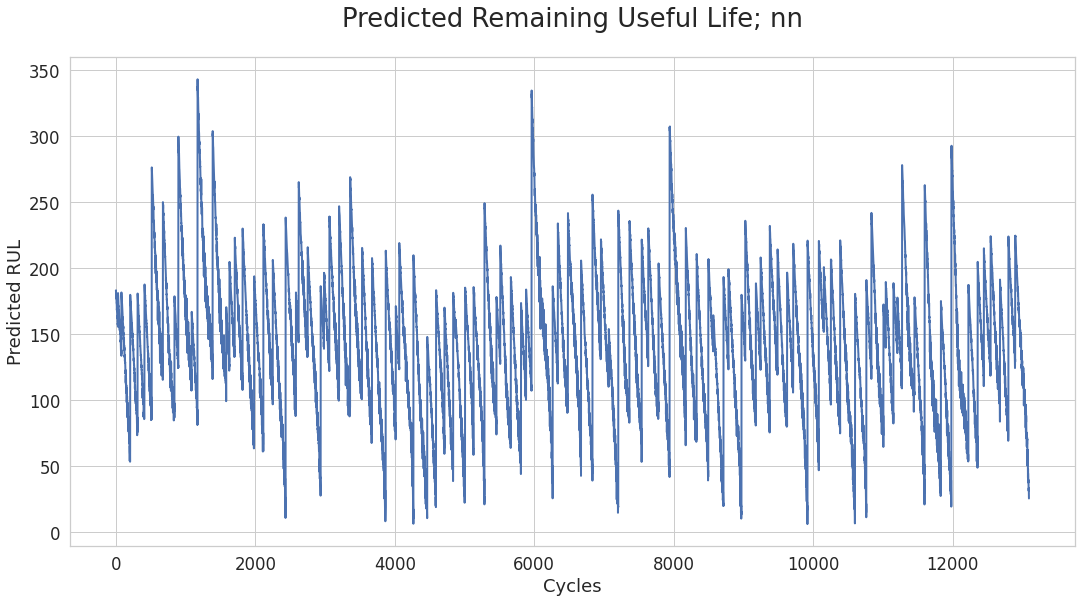

In [28]:
NeuralNetwork.PlotRUL(line_width=2)

We display engine unit 50 to have a better observation of the RUL results. In this example, can see that the RUL value decreases as the cycle as the cycle number increases. It shows that the engine displays degredation characteristics as time passes. At this point we can safely say that our method to predict the RUL is working. 

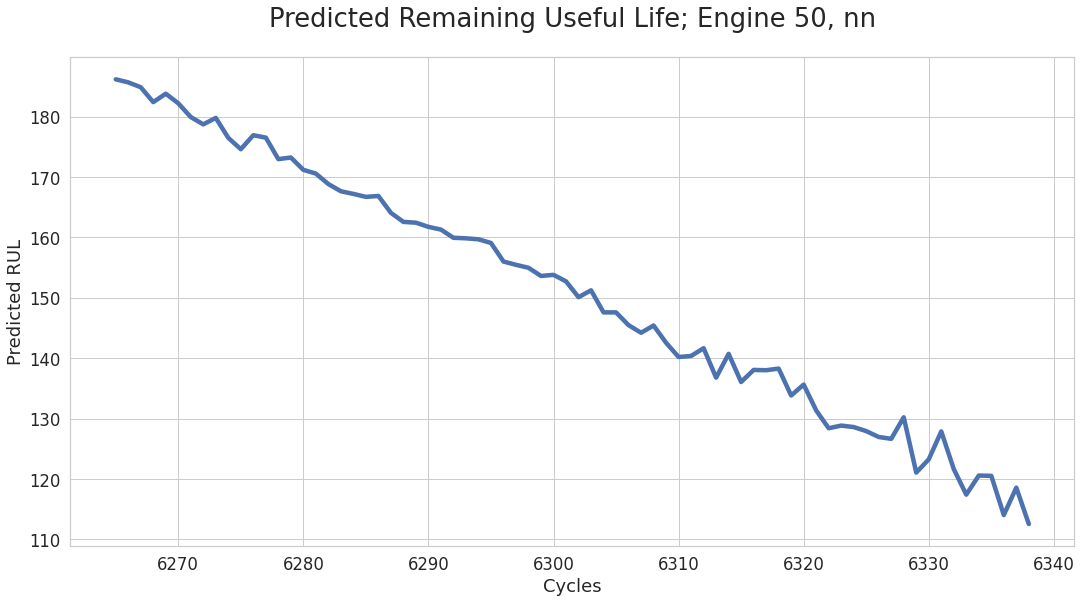

In [24]:
NeuralNetwork.PlotRUL(50, line_width=4.5)

To determine the accuracy of the model however, we will compare the RUL of the engines at their final cycle with the actual/true values. This will be done at the end when prediction is done with all three models. The other two models must first go through the same steps to predict the RUL of the test dataset.

## 6.2 K Nearest Neighbour Regressor prediction

In [18]:
KNRegressor = MachineLearningModel(knr_model, 'knr', df_test_FD001, X_test, Results_knr)
KNRegressor.predict()
KNRegressor.CalcPredMaxCycles()
RUL_knr = KNRegressor.CalcPredRUL()
KNRegressor.DataFrame()

,unit,cycles,Pred_H.I._knr,PredMaxCycles_knr,Pred_RUL_knr
0,1,1,1.000000,200.975441,200.975441
1,1,2,0.995414,200.975441,200.053722
2,1,3,0.989637,200.975441,198.892661
3,1,4,0.985814,200.975441,198.124375
4,1,5,0.979399,200.975441,196.835229
...,...,...,...,...,...
13091,100,194,0.150018,231.611993,34.746077
13092,100,195,0.198182,231.611993,45.901240
13093,100,196,0.147120,231.611993,34.074737
13094,100,197,0.146751,231.611993,33.989271


##6.3 Linear regression model prediction

In [19]:
LinearRegression = MachineLearningModel(lreg_model, 'lreg', df_test_FD001, X_test, Results_lreg)
LinearRegression.predict()
LinearRegression.CalcPredMaxCycles()
RUL_lreg = LinearRegression.CalcPredRUL()
LinearRegression.DataFrame()

,unit,cycles,Pred_H.I._lreg,PredMaxCycles_lreg,Pred_RUL_lreg
0,1,1,0.903406,149.373038,134.944430
1,1,2,0.910623,149.373038,136.022475
2,1,3,0.880623,149.373038,131.541287
3,1,4,0.885530,149.373038,132.274341
4,1,5,0.905769,149.373038,135.297434
...,...,...,...,...,...
13091,100,194,0.135680,227.602371,30.881130
13092,100,195,0.135120,227.602371,30.753589
13093,100,196,0.138762,227.602371,31.582520
13094,100,197,0.127759,227.602371,29.078230


#7. Results and analysis
At the end, we observe the prediction results of the Neural Network, KNN model and the Linear Regression model.

##7.1 Difference
We upload the actual/true RUL values of each engine units and compare their predicted RUL values. The difference between them are stored to determine the accuracy of our machine learning models by calculating the Root Mean Square Error (RMSE).

![difference calculation](https://drive.google.com/uc?id=1Un5nvlf3f5i63EdRZs5s2SUqPIrgGN-P)

In [20]:
FinalResult = pd.read_csv('/content/gdrive/My Drive/Capstone/RUL_FD001.txt', sep=' ', header=None)
FinalResult = FinalResult.dropna(axis=1, how='all')
FinalResult.columns = ["Actual RUL"]

unit = []
for i in range(1,101):
  unit.append(i)
FinalResult['Unit'] = unit

names = ['lreg', 'knr', 'nn']
models = [RUL_lreg, RUL_knr, RUL_nn]

for i in range(len(names)):
  predRUL_column_name = f'Pred_RUL_{names[i]}'
  diff_column_name = f'diff_{names[i]}'
  FinalResult[predRUL_column_name] = models[i]
  FinalResult[diff_column_name] = FinalResult['Actual RUL'] - FinalResult[predRUL_column_name]

FinalResult

,Actual RUL,Unit,Pred_RUL_lreg,diff_lreg,Pred_RUL_knr,diff_knr,Pred_RUL_nn,diff_nn
0,112,1,119.995048,-7.995048,166.747458,-54.747458,155.577972,-43.577972
1,98,2,105.525296,-7.525296,144.524841,-46.524841,133.558121,-35.558121
2,69,3,81.817143,-12.817143,45.422924,23.577076,53.309608,15.690392
3,82,4,99.963074,-17.963074,76.114550,5.885450,73.373322,8.626678
4,91,5,106.407354,-15.407354,87.856183,3.143817,85.590111,5.409889
...,...,...,...,...,...,...,...,...
95,137,96,152.315784,-15.315784,109.384751,27.615249,118.467880,18.532120
96,82,97,108.914928,-26.914928,81.120277,0.879723,83.692139,-1.692139
97,59,98,93.455681,-34.455681,67.493681,-8.493681,69.172104,-10.172104
98,117,99,165.614785,-48.614785,120.099532,-3.099532,124.278015,-7.278015


Plotting the absolute error distribution of the models below, the peak of the error distribution plot for all three models are slightly shifted towards the left. The left shift means that there is a tendancy for the difference between the actual and predicted RUL values to be negative to overshoot the actual values. 

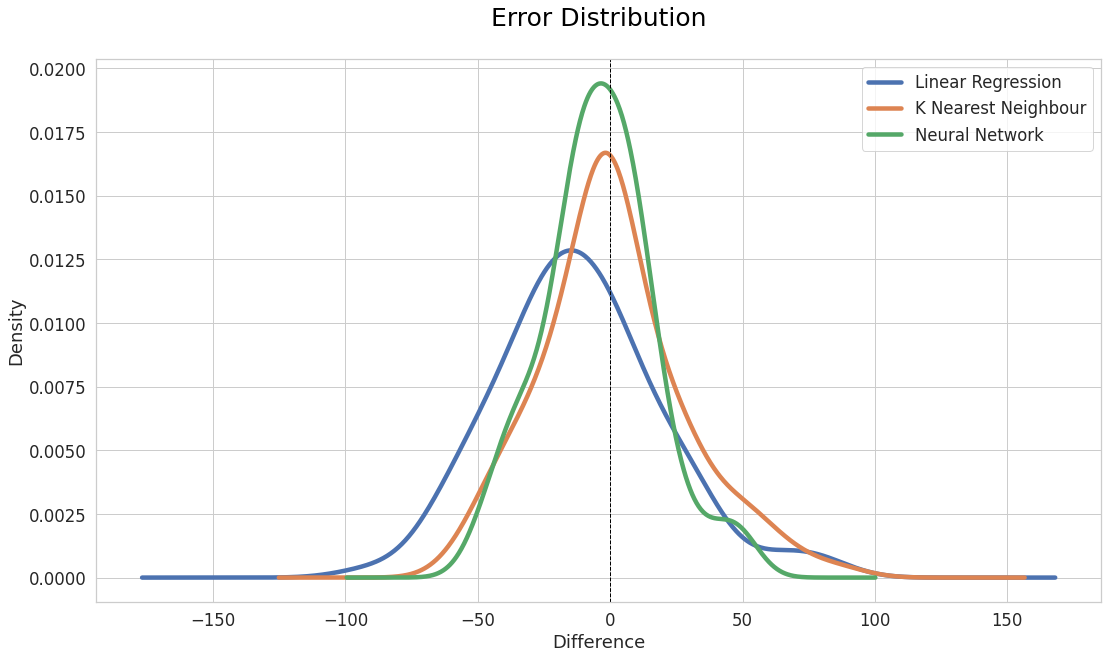

In [27]:
import matplotlib

plt.figure(figsize=(18,10))
plt.tight_layout()

sns.set_style('whitegrid')
sns.despine(bottom = False, left = False)
FinalResult['diff_lreg'].plot(label = 'Linear Regression', kind = 'kde', linewidth=4.5, legend = True)
FinalResult['diff_knr'].plot(label = 'K Nearest Neighbour', kind = 'kde', linewidth=4.5, legend = True)
FinalResult['diff_nn'].plot(label = 'Neural Network', kind = 'kde', linewidth=4.5, legend = True)
plt.axvline(0, color="black", linestyle='dashed', linewidth=1)

# set title and axis labels
errorDist = plt.title('Error Distribution', x=0.5, y=1.05, ha='center', fontsize='25')
plt.setp(errorDist, color = 'black')
plt.xlabel('Difference')
plt.show()

Text(0.5, 1.05, 'Error Distribution')

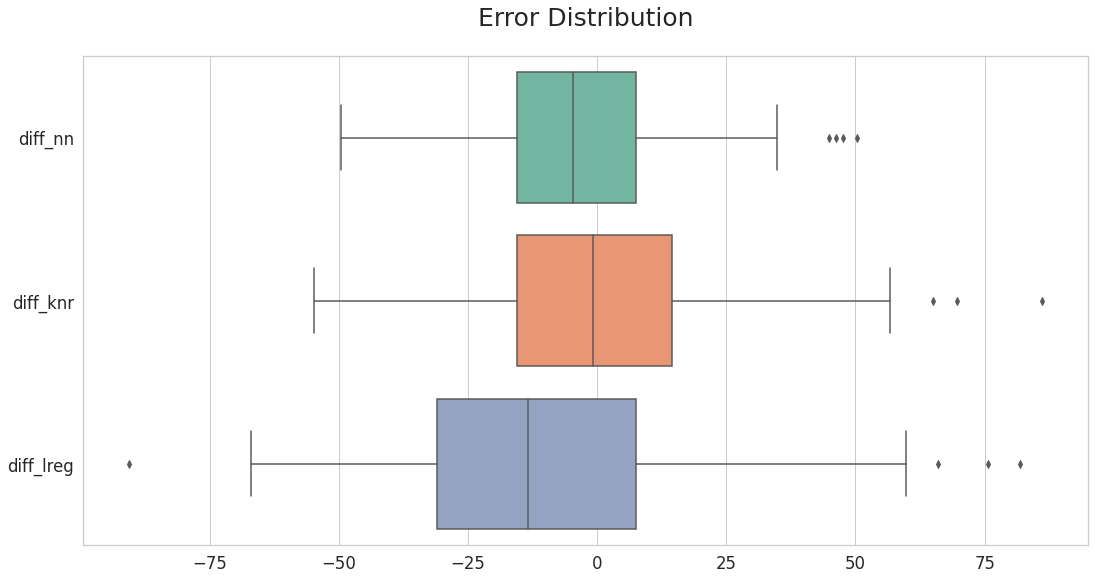

In [22]:
boxplot = FinalResult[['diff_nn','diff_knr','diff_lreg']]

sns.set_style('whitegrid')
plt.figure(figsize = (18, 9))
sns.boxplot(data=boxplot, orient="h", palette="Set2")
plt.title('Error Distribution', x=0.5, y=1.05, ha='center', fontsize = '25')

##7.3 Root Mean Square Error (RMSE)
RMSE is calculated by taking the square root of the average of the squared differences between the actual and predicted values. This value is able to represent the estimation of the the standard deviation σ of a typical observed value from the model’s prediction. In other words, a lower RMSE value means a more accurate prediction. The values obtained in this project is compared with the RMSE of existing works to ascertain the accuracy standing of our model.
<br>  
![RMSE calculation](https://miro.medium.com/max/725/1*lqDsPkfXPGen32Uem1PTNg.png) 

In [23]:
RMSE_nn = NeuralNetwork.GetRMSE(FinalResult['Actual RUL'], FinalResult['Pred_RUL_nn'])
RMSE_knr = KNRegressor.GetRMSE(FinalResult['Actual RUL'], FinalResult['Pred_RUL_knr'])
RMSE_lreg = LinearRegression.GetRMSE(FinalResult['Actual RUL'], FinalResult['Pred_RUL_lreg'])

print('Neural Network RMSE:', RMSE_nn)
print('K Nearest Neighbour RMSE:', RMSE_knr)
print('Linear Regression RMSE:', RMSE_lreg)

Neural Network RMSE: 21.111112570983536
K Nearest Neighbour RMSE: 27.203959610890887
Linear Regression RMSE: 33.49752785361099


#8. Conclusion
